In [36]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kern
from sklearn.model_selection import cross_validate
from sklearn.metrics import get_scorer_names
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_regression

PARENT_DIR = r'D:\projects\diverters\src'
CURR_DIR = os.path.join(PARENT_DIR, 'analysis_v1')
sys.path.append(PARENT_DIR)

In [16]:
def make_grid(_min_x, _max_x, _min_y, _max_y, _n, x_label='x', y_label='y'):
    _lin_x = np.linspace(_min_x, _max_x, _n)
    _lin_y = np.linspace(_min_y, _max_y, _n)
    _xv, _yv = np.array(np.meshgrid(_lin_x, _lin_y))
    return pd.DataFrame({x_label: _xv.ravel(), y_label: _yv.ravel()})

def plot_df(_df, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(_df.iloc[:, 0], _df.iloc[:, 1], _df.iloc[:, 2])

    col_names = _df.columns.tolist()
    ax.set_xlabel(col_names[0])
    ax.set_ylabel(col_names[1])
    ax.set_zlabel(col_names[2], labelpad=-2)

    if title:
        ax.set_title(title)

    plt.subplots_adjust(left=0.0, right=1.20, bottom=0.0, top=1.20)

    plt.show()

       heat_flux  mass_flow_rate  max_eqv_stress
0   1.418633e+07      159.775241      594.734108
1   5.632124e+06       81.715322      223.856768
2   1.413676e+07      284.012889      624.902001
3   2.378056e+06      170.033689      118.096912
4   3.431474e+06      268.576453      161.109517
..           ...             ...             ...
78  1.234670e+06      314.433498       81.922301
79  1.017163e+07      162.324257      425.294959
80  1.472996e+06       43.217991       79.000093
81  1.451143e+07       67.370005      511.799221
82  8.464530e+06      255.250384      366.396104

[83 rows x 3 columns]


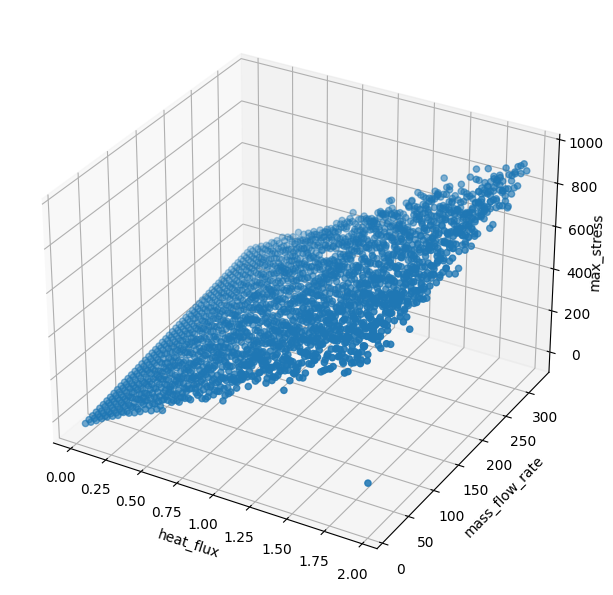

Train:	 RMS: [82.41539722 95.33045925 60.59815892]
Test:	 RMS: [ 80.42432494  44.53657836 115.47286257]

Train:	 R^2: [0.86832725 0.84265568 0.93008662]
Test:	 R^2: [0.88737369 0.95779706 0.76119178]


In [48]:
df = pd.read_csv(os.path.join(CURR_DIR, 'parametric.frame'), index_col=0)
x = df.iloc[:, 0]
y = df.iloc[:, 1]
z = df.iloc[:, 2]

print(df)

gpr_grid = make_grid(min(x), max(x), min(y), max(y), 50, x_label='heat_flux', y_label='mass_flow_rate')

gpr = GaussianProcessRegressor(kern.DotProduct() + kern.RBF())
gpr.fit(df.iloc[:, :2], df.iloc[:, 2])
gpr_grid['max_stress'] = gpr.predict(gpr_grid.iloc[:, :2])

plot_df(gpr_grid)

X_train = df.iloc[:, :2]
Y_train = df.iloc[:, 2]

model = make_pipeline(StandardScaler(), LinearRegression())

results = cross_validate(estimator=model, X=X_train, y=Y_train, cv=3, scoring=['neg_mean_squared_error', 'r2'], return_train_score=True)
print(f"Train:\t RMS: {(results['train_neg_mean_squared_error'] * -1) ** 0.5}")
print(f"Test:\t RMS: {(results['test_neg_mean_squared_error'] * -1) ** 0.5}\n")
print(f"Train:\t R^2: {results['train_r2']}")
print(f"Test:\t R^2: {results['test_r2']}")